## Compute → Data

This Jupyter kernel is running in Azure. We've moved the compute to the data!

For those interested, we used the [DaskHub](https://github.com/dask/helm-chart/blob/main/daskhub/README.md) Helm chart to install JupyterHub and Dask Gateway onto Azure Kubernetes Service.

As a user, you just log in and get your compute.

Dask + JupyterHub is just one of many ways to get compute on Azure. The important thing is that it's next to the data. Let's consider the simple task of reading the metadata from a COG file with `gdalinfo`.

Running this command from my laptop in Des Moines, IA, we spend a *lot* of time waiting:

```console
$ time gdalinfo /vsicurl/https://naipeuwest.blob.core.windows.net/naip/v002/ia/2019/ia_60cm_2019/42091/m_4209150_sw_15_060_20190828.tif > /dev/null
real    0m7.158s
user    0m0.195s
sys     0m0.032s
```

In [1]:
!time gdalinfo /vsicurl/https://naipeuwest.blob.core.windows.net/naip/v002/ia/2019/ia_60cm_2019/42091/m_4209150_sw_15_060_20190828.tif > /dev/null


real	0m0.216s
user	0m0.059s
sys	0m0.031s


## Scaling

We want to enable computations on large datasets, without requiring (much) expertise in distributed computing. We *really* don't want our users worrying about things like Kubernetes tolerations.

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
client = cluster.get_client()
cluster.scale(80)
cluster

## File formats

Doing geospatial analysis on the cloud presents opportunities and challenges. One of the primary challenges, which has both technical and social components, is around file formats. 

In 2018, Matt Rocklin laid out the challenges with using [HDF5 in the cloud](https://matthewrocklin.com/blog/work/2018/02/06/hdf-in-the-cloud). In short, the APIs and performance characteristics of filesystems like S3, Google Cloud Storage, and Azure Blob Storage are sufficiently different from HPC and local filesystems that we can't just "move the compute to the data".

In [2]:
import planetary_computer
import xarray as xr
import fsspec
import pystac_client
import xarray as xr

We'll use the Planetary Computer's STAC API to search for data from the [NASA NEX-GDDP CMIP6 Downscaling](https://planetarycomputer.microsoft.com/dataset/nasa-nex-gddp-cmip6) dataset.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

search = catalog.search(
    collections=["nasa-nex-gddp-cmip6"],
    datetime="1950/2000",
    query={"cmip6:model": {"eq": "ACCESS-CM2"}},
)
items = search.get_all_items()
len(items)

51

Each one of those STAC items has several assets, which are links pointing to HDF5 files in Azure Blob Storage. For example, the file for precipitation:

In [4]:
items[0].assets["pr"].href

'https://nasagddp.blob.core.windows.net/nex-gddp-cmip6/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/pr/pr_day_ACCESS-CM2_historical_r1i1p1f1_gn_2000.nc'

So, we have a URL to a NetCDF file. At this point, the "download" model would say download it to a local disk.

```python
>>> filename, _ = urllib.request.urlretrieve(items[0].assets["pr"].href)
```

But let's avoid that temptation. We'll try to stream the data directly from Blob Storage into memory.

We can't just pass the URL to `xarray.open_dataset`. Libraries like `libhdf`, and `libnetcdf` assume they're working with a local filesystem, and are being passed "real" files.

```pytb
>>> xr.open_dataset(item.assets["pr"].href)
Traceback (most recent call last):

  ...
  
  File src/netCDF4/_netCDF4.pyx:2307 in netCDF4._netCDF4.Dataset.__init__

  File src/netCDF4/_netCDF4.pyx:1925 in netCDF4._netCDF4._ensure_nc_success

OSError: [Errno -75] NetCDF: Malformed or unexpected Constraint: b'https://nasagddp.blob.core.windows.net/nex-gddp-cmip6/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/pr/pr_day_ACCESS-CM2_historical_r1i1p1f1_gn_2000.nc'
```

So there's no "just move the compute to the data". Embracing cloud-native workflows does required some effort.

The pangeo community has been working on this problem for several years now, along a few avenues.

* We've worked with data providers to promote cloud-friendly formats like Zarr and TileDB
* We've worked on libraries like `fsspec` to provide access to remote filesystems
* We've worked on "cloud-optimized index files" that give more efficient access to the same data stored in HDF5


In [5]:
%%time
item = planetary_computer.sign(items[0])
fake_file = fsspec.open(item.assets["pr"].href).open()

ds = xr.open_dataset(fake_file, engine="h5netcdf")
ds

CPU times: user 553 ms, sys: 68.5 ms, total: 622 ms
Wall time: 1.81 s


<xarray.Dataset>
Dimensions:  (time: 366, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    pr       (time, lat, lon) float32 ...
Attributes: (12/22)
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T14:00:03.710042+00:00
    frequency:             day
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    ...                    ...
    history:               2021-10-04T14:00:03.710042+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0

But notice, it takes about a second to load just the metadata for that single file. Repeating that for every data variable becomes a bit painful.

In [6]:
%%time

ds = xr.open_mfdataset(
    [fsspec.open(asset.href).open() for asset in item.assets.values()]
)
ds

CPU times: user 1.15 s, sys: 248 ms, total: 1.4 s
Wall time: 5.53 s


<xarray.Dataset>
Dimensions:  (time: 366, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    hurs     (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
    huss     (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
    rlds     (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
    rsds     (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
    sfcWind  (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
Attributes: (12/22)
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T13:59:35.374080+00:00
    frequency:             day
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    ...                    ...
    history:               2021-10-04T13:59:35.374080+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0

And repeating that for every year (65 years in this case) really precludes any kind of interactive workflow. In short: we can't just assume the same libraries and workflows designed for HPC / local compute and file systems will work well with the cloud.

We can work with the data providers to produce cloud-friendly data formats like TileDB or Zarr. This is a hard problem, socially and technically. Or we can do the conversion ourselves;

In [7]:
%%time
imerg = catalog.get_collection("gpm-imerg-hhr")
asset = planetary_computer.sign(imerg.assets["zarr-abfs"])
fs = fsspec.get_mapper(asset.href, **asset.extra_fields["xarray:storage_options"])
ds = xr.open_zarr(fs, **asset.extra_fields["xarray:open_kwargs"])
ds

CPU times: user 1.95 s, sys: 115 ms, total: 2.06 s
Wall time: 2.8 s


<xarray.Dataset>
Dimensions:                         (time: 368160, lon: 3600, lat: 1800,
                                     latv: 2, lonv: 2, nv: 2)
Coordinates:
  * lat                             (lat) float32 -89.95 -89.85 ... 89.85 89.95
    lat_bnds                        (lat, latv) float32 dask.array<chunksize=(1800, 2), meta=np.ndarray>
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
    lon_bnds                        (lon, lonv) float32 dask.array<chunksize=(3600, 2), meta=np.ndarray>
  * time                            (time) object 2000-06-01 00:00:00 ... 202...
    time_bnds                       (time, nv) object dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: latv, lonv, nv
Data variables:
    HQobservationTime               (time, lon, lat) timedelta64[ns] dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    HQprecipSource                  (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    HQprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    precipitationCal                (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    precipitationUncal              (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

An alternative workflow is to produce a cloud-optimized "index" file, which contains just the metadata and references to the actual data, which are still stored in HDF5.

In [8]:
import requests

collection = catalog.get_collection("nasa-nex-gddp-cmip6")
references = requests.get(collection.assets["ACCESS-CM2.historical"].href).json()
references = planetary_computer.sign(references)

In [9]:
%%time
reference_filesystem = fsspec.filesystem("reference", fo=references)

ds = xr.open_dataset(
    reference_filesystem.get_mapper("/"),
    engine="zarr",
    backend_kwargs={"consolidated": False},
    chunks={},
)
ds

CPU times: user 1.19 s, sys: 21.4 ms, total: 1.21 s
Wall time: 1.37 s


<xarray.Dataset>
Dimensions:  (time: 23741, lat: 600, lon: 1440)
Coordinates:
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[us] 1950-01-01T12:00:00 ... 2014-12-31T12:00:00
Data variables:
    hurs     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    huss     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    rlds     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    rsds     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    sfcWind  (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/22)
    Conventions:           CF-1.7
    activity:              NEX-GDDP-CMIP6
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    cmip6_source_id:       ACCESS-CM2
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    scenario:              historical
    source:                BCSD
    title:                 ACCESS-CM2, r1i1p1f1, historical, global downscale...
    tracking_id:           16d27564-470f-41ea-8077-f4cc3efa5bfe
    variant_label:         r1i1p1f1
    version:               1.0

So now in about 1-2 seconds, we have all the ~600 TB of data at our fingertips.

Cloud-friendly file formats like Zarr, TileDB, or "reference" approaches like Kerchunk are crucial for interactive data analysis on large datasets.

## Example workflow

We'll again use STAC to search for and load up the STAC items.

In [10]:
import pystac_client

catalog = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/"
)
search = catalog.search(
    collections=["era5-pds"],
    datetime="2010/2020",
    query={"era5:kind": {"eq": "fc"}}
)
items = sorted(
    planetary_computer.sign(search.get_all_items()),
    key=lambda x: x.properties["start_datetime"]
)

len(items)

132

These items link back to Zarr datasets, and we have one item per month. But even with this cloud-friendly Zarr format, we still face issues getting this into a nice datacube: Zarr doesn't *currently* support variable-length chunks, and months are variable length.

So let's load up just a few year's worth of data.

In [11]:
%%time
datasets = []
# for item in items:

for item in items[:48]:
    asset = item.assets["air_temperature_at_2_metres_1hour_Maximum"]
    datasets.append(xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"]))

ds = xr.combine_by_coords(datasets, join="exact", combine_attrs="drop_conflicts")
t2 = ds.air_temperature_at_2_metres_1hour_Maximum
t2

CPU times: user 3.45 s, sys: 146 ms, total: 3.6 s
Wall time: 12.2 s


,Array,Chunk
Bytes,135.62 GiB,31.93 MiB
Shape,"(35064, 721, 1440)","(372, 150, 150)"
Count,9648 Tasks,4800 Chunks
Type,float32,numpy.ndarray


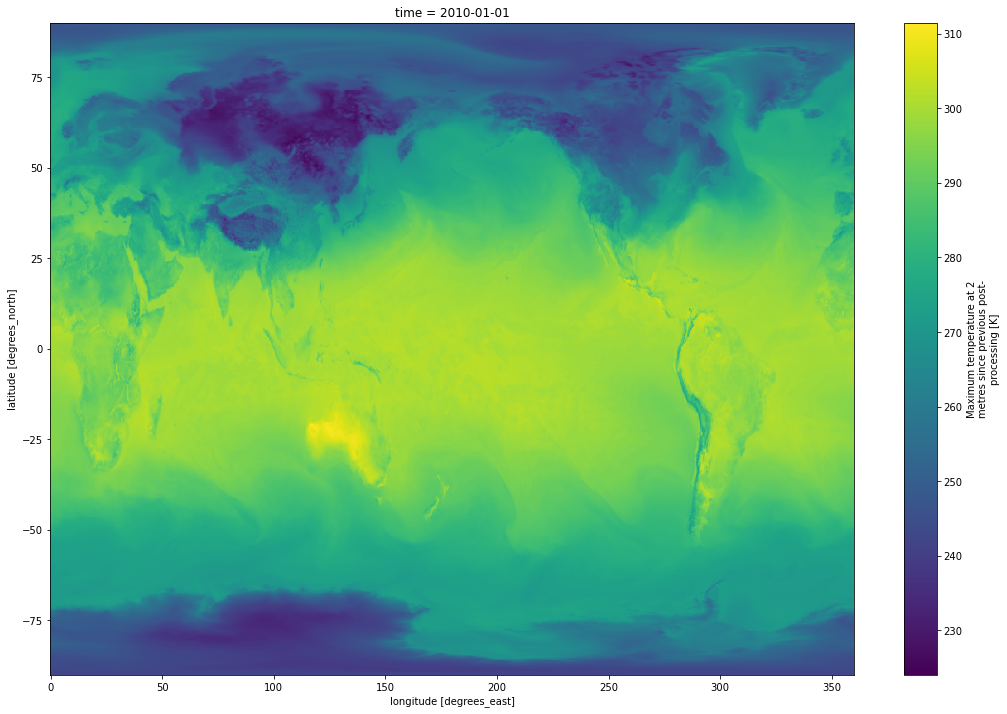

In [12]:
t2.isel(time=0).plot(size=12);

As a semi-realistic workflow, let's compute a daily climatology on this data. Ideally we'd just write

```python
>>> daily_climatology = t2.groupby("time.dayofyear").mean()
```

But there are some problems in xarray and Dask that make this not work so well. Deepak Cherian (NCAR) and Anderson Banihirwe (Carbonplan) are working on implementing some smarter algorithms in [flox](https://flox.readthedocs.io/) and integrating them into xarray in https://github.com/pydata/xarray/pull/5734. Once those are in, we'll be able to write our `groupby` like above.

In [13]:
import flox.xarray

daily_climatology = flox.xarray.xarray_reduce(t2, t2.time.dt.dayofyear, func="mean")
daily_climatology = daily_climatology.persist()
daily_climatology

<xarray.DataArray 'air_temperature_at_2_metres_1hour_Maximum' (dayofyear: 366,
                                                               lat: 721,
                                                               lon: 1440)>
dask.array<transpose, shape=(366, 721, 1440), dtype=float32, chunksize=(366, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon        (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    long_name:       Maximum temperature at 2 metres since previous post-proc...
    nameECMWF:       Maximum temperature at 2 metres since previous post-proc...
    product_type:    forecast
    shortNameECMWF:  mx2t
    standard_name:   air_temperature
    units:           K

And we can plot that, averaged over the globe.

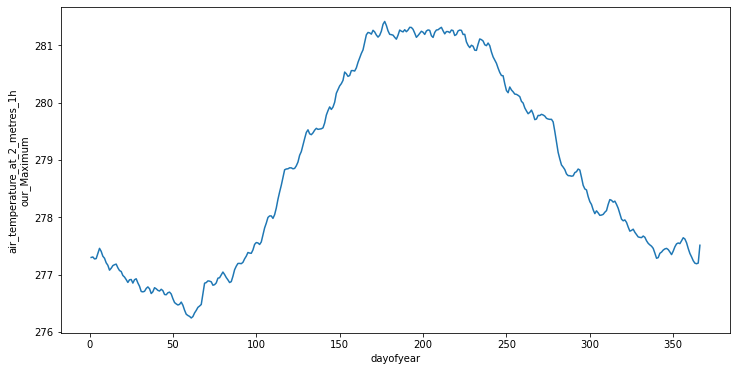

In [15]:
daily_climatology.mean(dim=("lat", "lon")).plot(size=6, aspect=2);

The next step, according to my internet search, was to calculate an anomaly.

In [16]:
def calculate_anomaly(block, daily_climatology):
    return block.groupby("time.dayofyear") - daily_climatology

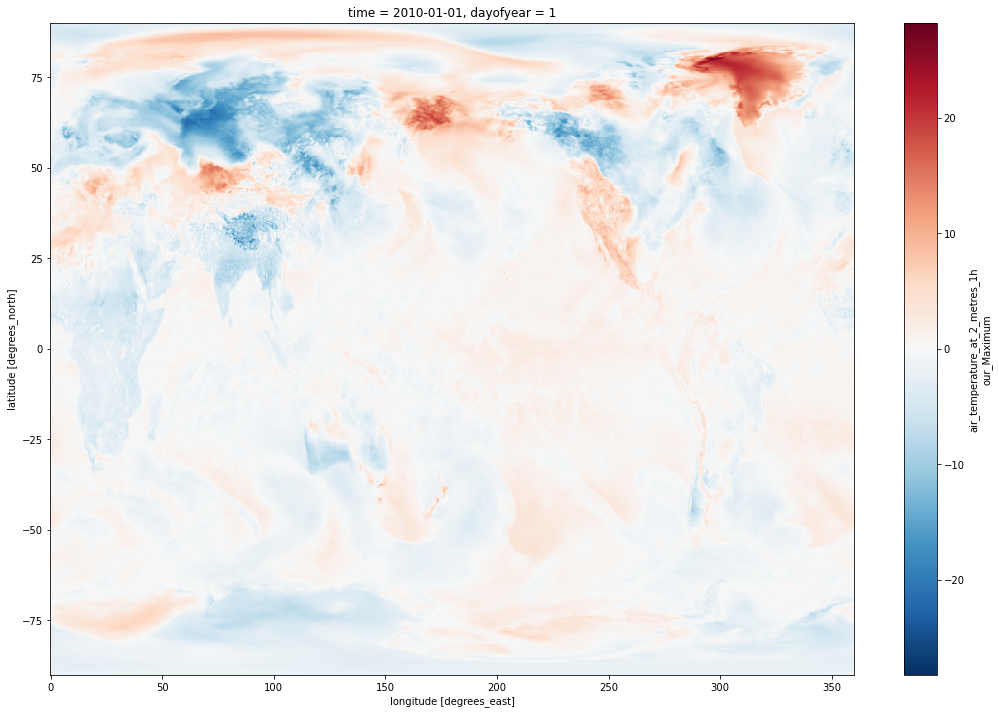

In [17]:
x = calculate_anomaly(t2.isel(time=[0]), daily_climatology)
x.compute().plot(size=12);

This again requires some care to [ensure we're using Dask efficently](https://gist.github.com/rabernat/30e7b747f0e3583b5b776e4093266114). We'll use `map_blocks`.

In [18]:
anomaly = t2.map_blocks(
    calculate_anomaly,
    template=t2.assign_coords(dayofyear=ds.time.dt.dayofyear),
    args=(daily_climatology,)
)
anomaly

<xarray.DataArray 'air_temperature_at_2_metres_1hour_Maximum' (time: 35064,
                                                               lat: 721,
                                                               lon: 1440)>
dask.array<<this-array>-calculate_anomaly, shape=(35064, 721, 1440), dtype=float32, chunksize=(372, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2010-01-01 ... 2013-12-31T23:00:00
    dayofyear  (time) int64 dask.array<chunksize=(372,), meta=np.ndarray>
Attributes:
    long_name:       Maximum temperature at 2 metres since previous post-proc...
    nameECMWF:       Maximum temperature at 2 metres since previous post-proc...
    product_type:    forecast
    shortNameECMWF:  mx2t
    standard_name:   air_temperature
    units:           K

I kicked off that computation and then used `xmovie` to stitch together a handful of frames into a movie. With that, I was able to pretty quickly spot that something was off.

```python
>>> anomaly = anomaly.persist()
>>> import xmovie
>>> movie = xmovie.Movie(anomaly[:24], vmin=-15, vmax=15, cmap="RdBu")
>>> movie.save("movie.mp4", overwrite_existing=True, progress=True)
```

In [21]:
from IPython.display import Video

Video(filename="movie.mp4", html_attributes="controls loop")

This ERA5 data is hourly. The examples I was copying from were working with daily resolution data. So we can resample the hourly data to daily, and get a more meanigful result.

In [19]:
## daily = t2.resample(time="1D").mean().rename(round="time")
daily = (
    flox.xarray.xarray_reduce(
        t2,
        t2.time.dt.round("D"),
        func="mean",
        method="blockwise"
    ).rename(round="time")
    .persist()
)
daily

,Array,Chunk
Bytes,5.65 GiB,1.37 MiB
Shape,"(1462, 721, 1440)","(16, 150, 150)"
Count,4800 Tasks,4800 Chunks
Type,float32,numpy.ndarray


In [20]:
daily2 = daily.assign_coords(dayofyear=daily.time.dt.dayofyear)
anomaly = daily2.map_blocks(
    calculate_anomaly,
    args=(daily_climatology,),
    template=daily2
)
anomaly

<xarray.DataArray 'air_temperature_at_2_metres_1hour_Maximum' (time: 1462,
                                                               lat: 721,
                                                               lon: 1440)>
dask.array<<this-array>-calculate_anomaly, shape=(1462, 721, 1440), dtype=float32, chunksize=(16, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2014-01-01
    dayofyear  (time) int64 dask.array<chunksize=(16,), meta=np.ndarray>
Attributes:
    long_name:       Maximum temperature at 2 metres since previous post-proc...
    nameECMWF:       Maximum temperature at 2 metres since previous post-proc...
    product_type:    forecast
    shortNameECMWF:  mx2t
    standard_name:   air_temperature
    units:           K

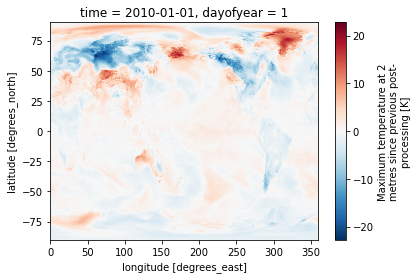

In [21]:
anomaly[0].compute().plot();

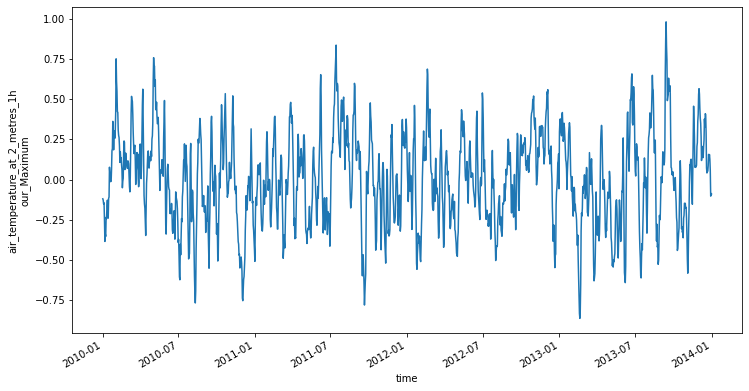

In [22]:
ts = anomaly.mean(dim=["lat", "lon"]).compute()

ts.plot(size=6, aspect=2);

In [ ]:
# movie = xmovie.Movie(anomaly, vmin=-15, vmax=15, cmap="RdBu")
# movie.save("movie-daily.mp4", overwrite_existing=True, progress=True)

In [15]:
from IPython.display import Video

Video(filename="movie-daily.mp4", html_attributes="controls loop")

In [26]:
cluster.close()

To summarize

* Able to create a cluster of machines, without having to think about infrastructure
* Able to parallelize our computation (with a bit of thought and care)
* Able to *quickly* explore this dataset, spot and correct errors 